In [1]:
from osgeo import gdal, osr
import numpy as np

In [2]:
from shutil import copyfile, move # Utilities for copying and moving files
from osgeo import gdal, osr            # GDAL support for reading virtual files
import os                         # To create and remove directories
import matplotlib.pyplot as plt   # For plotting
import numpy as np  
import fiona
import netCDF4
import rasterio
from rasterio.mask import mask

In [6]:
%cd /home/ayush12gupta/Desktop/ugp/analysis2/offset_track

/home/ayush12gupta/Desktop/ugp/analysis2/offset_track


In [62]:
# ls ..
dimidX = 3248
# 3240
tran = [675761.6745032677, 27.724848095791316, 0.0, 3628850.2117641964, 0.0, -27.724848095791316]
# tran = [674791.3048199151, 27.724848095791316, 0.0, 3628850.2117641964, 0.0, -27.724848095791316]
x = np.arange(tran[0],tran[0]+tran[1]*(dimidX-1),tran[1])
print(x.shape)
x = np.linspace(x[0], x[-1], dimidX)
x.shape[0]
# c = 0.3
# np.arange(0.1, 0.1 + c*(6-1), c)
# x[-5:]

(3247,)


3248

In [33]:
import os
from osgeo import gdal
from osgeo import osr
import numpy

# config
GDAL_DATA_TYPE = gdal.GDT_Float64 
GEOTIFF_DRIVER_NAME = "GTiff"
NO_DATA = -32767
SPATIAL_REFERENCE_SYSTEM_WKID = 32767

def create_raster(output_path,
                  columns,
                  rows,
                  nband = 1,
                  gdal_data_type = GDAL_DATA_TYPE,
                  driver = GEOTIFF_DRIVER_NAME):

    driver = gdal.GetDriverByName(driver)

    output_raster = driver.Create(output_path, int(columns), int(rows), nband, eType = gdal_data_type)    
    return output_raster

def numpy_array_to_raster(output_path,
                          numpy_array,
                          proj,
                          trans,
                          nband = 1,
                          no_data = NO_DATA,
                          gdal_data_type = GDAL_DATA_TYPE,
                          spatial_reference_system_wkid = SPATIAL_REFERENCE_SYSTEM_WKID,
                          driver = GEOTIFF_DRIVER_NAME):


    shp = numpy_array.shape
    rows, columns = shp[1], shp[2]
    print(rows, columns)
    output_raster = create_raster(output_path, int(columns), int(rows), nband, gdal_data_type) 
    geotransform = trans
    print(geotransform)

    spatial_reference = osr.SpatialReference()
    spatial_reference.ImportFromWkt(proj)
    # spatial_reference.ImportFromProj4('+proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=95 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
    output_raster.SetProjection(spatial_reference.ExportToWkt())
    output_raster.SetGeoTransform(geotransform)
    for i in range(1, nband+1):
        print(i)
        output_band = output_raster.GetRasterBand(i)
        output_band.SetNoDataValue(no_data)
        output_band.WriteArray(numpy_array[i-1])          
        output_band.FlushCache()
#         print(output_raster.GetProjection())
    
    return  output_raster

In [5]:
def cropRaster(shape_filenm, raster_filenm, cropped_filenm):
    # Read Shape file
    with fiona.open(shape_filenm, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    # read imagery file
    with rasterio.open(raster_filenm) as src:
        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = src.meta
    print(out_transform)

    # Save clipped imagery
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(cropped_filenm, "w", **out_meta) as dest:
        dest.write(out_image)
        
def smooth(scalars, weight: float):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

In [6]:
# fn = 'feb2_G0028V02_P097.nc'
def generateCrops(fn):
    file2read = netCDF4.Dataset(fn,'r')
    nm = fn.split('_')[0]
    os.makedirs(fn.split('_')[0][:-1], exist_ok=True)
    os.chdir(fn.split('_')[0][:-1])
    fls = os.listdir('./')
    for f in fls:
        if nm in f:
            print("Skipping ", nm)
            os.chdir('..')
            return
    
    #-----Params for velocity processing----------------
    shapefile_dir = '../../chandra_bhaga/' ## Hard Coded
    incidenceAngle = file2read['img_pair_info'].incidence_angle
    deg2rad = np.pi/180
    sin_incid = np.sin(incidenceAngle*deg2rad)
    cos_incid = np.cos(incidenceAngle*deg2rad)

    #----------- Angle u-----------------------
    demsp = gdal.Open('../../dem_test.tif')   ## Hard Coded
    projs = demsp.GetProjection()
    geo = demsp.GetGeoTransform()
    nodata = demsp.GetRasterBand(1).GetNoDataValue()
    angle_u = demsp.GetRasterBand(1).ReadAsArray()*deg2rad
    angle_u_nodt = (angle_u==nodata)
    demsp = None

    #----------- Compute angle V------------------------
    vr = np.array(file2read['vr']).astype(float)
    vr_nodt = (vr==-32767)
    vr[vr_nodt] = 0  #np.nan
    va = np.array(file2read['va']).astype(float)
    va_nodt = (va==-32767)
    va[va_nodt] = 0  #np.nan

    nodata = (va!=0)
    tmp = np.zeros_like(vr)
    tmp[nodata] = (vr*sin_incid)[nodata]/va[nodata]
    angle_v = np.arctan(tmp)

    ## VF
    vf = vr*(((np.cos(angle_u)* np.sin(angle_v))*sin_incid) - (cos_incid*np.sin(angle_u))) + va*(np.cos(angle_u)*np.cos(angle_v))
    vf[angle_u_nodt] = 0
    vf[va_nodt] = -32767
    vf[vr_nodt] = -32767
    ## VN
    vn = vr*(((np.sin(angle_u)* np.sin(angle_v))*sin_incid) - (cos_incid*np.cos(angle_u))) + va*(np.sin(angle_u)*np.cos(angle_v))
    vn[angle_u_nodt] = 0
    vn[va_nodt] = -32767
    vn[vr_nodt] = -32767
    ds = numpy_array_to_raster('tmp_V.tif', np.array([vf, vn]), projs, geo, nband=2)
    ds.FlushCache()
    ds = None
    cropRaster(shapefile_dir + 'CBbasin.shp', 'tmp_V.tif', nm+'_V_basin.tiff')
    cropRaster(shapefile_dir + 'CBbasin_full.shp', 'tmp_V.tif', nm+'_V_full.tiff')
    os.remove('tmp_V.tif')
    os.chdir('..')

In [5]:
ls

runtime.txt   stack_12_14/  stack_4_5/   stack_8_9/
stack_0_1/    stack_1_3/    stack_4_6/   stack_9_10/
stack_0_2/    stack_13_14/  stack_5_6/   stack_9_11/
stack_10_11/  stack_13_15/  stack_5_7/   testGeogrid.txt
stack_10_12/  stack_14_15/  stack_6_7/   window_location.tif
stack_11_12/  stack_2_3/    stack_6_8/   window_rdr_off2vel_x_vec.tif
stack_11_13/  stack_2_4/    stack_7_8/   window_rdr_off2vel_y_vec.tif
stack_1_2/    stack_3_4/    stack_7_9/
stack_12_13/  stack_3_5/    stack_8_10/


In [47]:
a= np.array([True, False, False, True])
b= np.array([True, True, False, False])
a|b

array([ True,  True, False,  True])

In [55]:
def read_vals(fn, nodat=None, band=1):
    ds = demsp = gdal.Open(fn)
    disp = ds.GetRasterBand(band).ReadAsArray()
    nodata = np.isnan(disp)
    disp[nodata] = -32767
    if nodat is not None:
        disp[nodat] = -32767
    ds = None
    nodata = (nodat|nodata)
    return disp, nodata

In [56]:
# Reading file v01, v02, v03, v12, v23
ds01 = demsp = gdal.Open('2019-05-21_2.tif')   ## Hard Coded
projs = demsp.GetProjection()
geo = demsp.GetGeoTransform()
disp01 = ds01.GetRasterBand(1).ReadAsArray()#*12
shp = disp01.shape
nodata = np.isnan(disp01)
#ds01.GetRasterBand(1).GetNoDataValue()
disp01[nodata] = -32767
disp02, nodata = read_vals('2019-06-02_2.tif', nodata)#*24
disp03, nodata = read_vals('2019-06-14_2.tif', nodata)#*36
disp03, nodata = read_vals('2019-06-26_2.tif', nodata)#*48
disp04, nodata = read_vals('2019-07-20_2.tif', nodata)#*48
disp12, nodata = read_vals('2019-06-02.tif', nodata)#*12
disp23, nodata = read_vals('2019-06-14.tif', nodata)#*12
disp34, nodata = read_vals('2019-06-26.tif', nodata)#*12
disp13, nodata = read_vals('2019-06-02_3.tif', nodata)#*12
disp24, nodata = read_vals('2019-06-14_3.tif', nodata)#*12

In [65]:
L = np.array([disp12, disp23, disp34, disp13, disp24]).reshape(5,-1)
A = np.array([[1, 0, 0], [0,1,0],[0,0,1],[-1, 2, 0], [0,-2,3]])
A = np.array([[-1, 2, 0,0], [0,-2,3,0], [0,0,-3,4],[-0.5,0,1.5,0], [0,-1,0,2]])
X_init = np.array([disp01, disp02, disp03, disp04]).reshape(4, -1).reshape(4, shp[0], shp[1])

P = np.identity(5)*0.01 #[[1, 0, 0], [0, 1, 0], [0,0,1]]
# P[3,3] *= 5
# P[4,4] *= 5
print(L.shape)
N = (np.transpose(A)@P@A)
X_bar = np.matmul(np.matmul(numpy.linalg.inv(N), (np.transpose(A)@P)), L).reshape(4, shp[0], shp[1])
X_bar[:,nodata] = -32767

(5, 8757500)


In [81]:
M, N = A.shape
U, s, VT = np.linalg.svd(A, full_matrices=True)
sigm = np.zeros((M, N))
sigm[:N, :N] = np.diag(s)
# Check
# print(U.dot(sigm).dot(VT) - A)

[[ 4.44089210e-16 -4.44089210e-16 -6.66133815e-16  1.11022302e-16]
 [ 2.77555756e-16 -1.33226763e-15  1.77635684e-15 -1.99840144e-15]
 [ 3.46944695e-16 -1.11022302e-15 -8.88178420e-16  1.77635684e-15]
 [ 3.33066907e-16 -7.77156117e-16  2.22044605e-16 -8.32667268e-16]
 [ 2.77555756e-16 -1.11022302e-15  4.44089210e-16 -2.22044605e-16]]


In [82]:
S_inv = np.zeros(A.shape).T
S_inv[:N-1,:N-1] = np.diag(1/s[:N-1])
# S_inv.round(3)
# v_new = ((vh@np.linalg.inv(sigm))@np.transpose(u))

In [89]:
N = VT.T.dot(S_inv).dot(U.T)
x_svd = (N@L).reshape(4, shp[0], shp[1])
x_svd[:,nodata] = -32767

In [92]:
i = 2
ds = numpy_array_to_raster(f'../V_svd0{str(i)}.tif', np.array([x_svd[i], X_init[i]]), projs, geo, nband=2)
ds.FlushCache()
ds = None

2825 3100
(675586.0022161611, 28.56256610597833, 0.0, 3629309.953301915, 0.0, -28.559991329753643)
1
2


In [66]:
La = (A@(X_bar.reshape(4,-1)))
# N = np.matmul((np.transpose(A)@P),A)
# X_bar = np.matmul(np.matmul(numpy.linalg.inv(N), (np.transpose(A)@P)), La).reshape(4, shp[0], shp[1])
# X_bar[:,nodata] = -32767

In [75]:
Resid = (A@(X_bar.reshape(4,-1))) - L
Resid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
Residi = (A@(X_init.reshape(4,-1))) - L
Residi

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
orth = np.transpose(A)@P@L
orth[:,nodata.reshape(-1)] = -1
orth[:,4000000]

array([-2.77077795e-05,  4.49527693e-05,  1.99061995e-04, -2.44490414e-04])

In [67]:
i = 1
ds = numpy_array_to_raster(f'../V0{str(i)}.tif', np.array([X_bar[i], X_init[i]]), projs, geo, nband=2)
ds.FlushCache()
ds = None

2825 3100
(675586.0022161611, 28.56256610597833, 0.0, 3629309.953301915, 0.0, -28.559991329753643)
1
2


In [17]:
orth = np.transpose(A)@P@La

In [74]:
(Resid[:,nodata.reshape(-1)]>50).sum()


289566

In [33]:
# (Residi[:,nodata.reshape(-1)]>50).sum()
x = np.array([X_bar[i], X_init[i]])

/home/ayush12gupta/anaconda3/envs/ISCE2/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


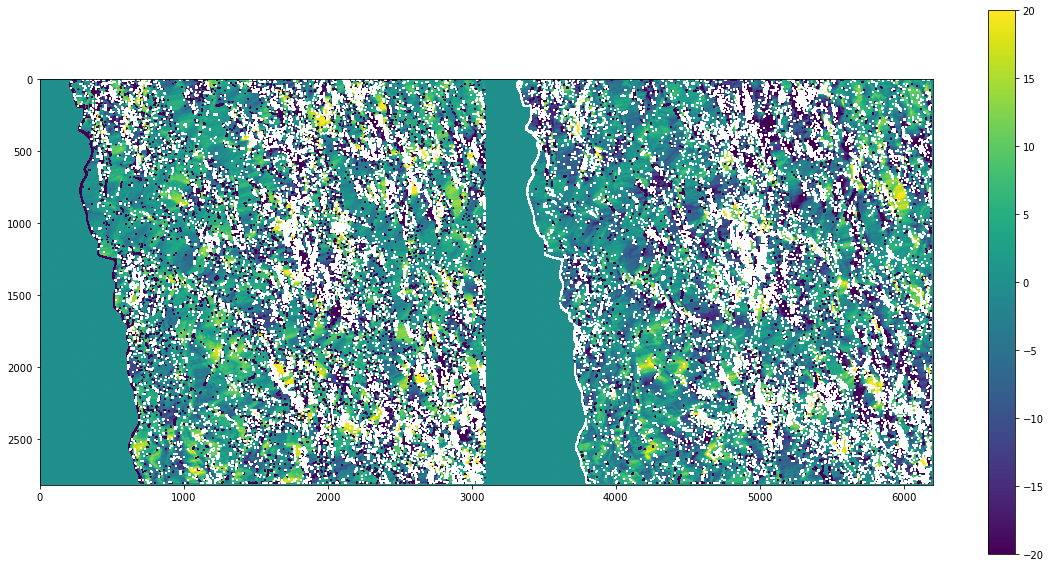

In [72]:
fig = plt.figure(figsize=(20,10))
i = 4
st = np.hstack([Resid[i].reshape(shp[0], shp[1]),Residi[i].reshape(shp[0], shp[1])])
st[st>50] = np.nan
plt.imshow(st, vmax=20, vmin=-20)
plt.colorbar()
# disp01

In [30]:
def read_vals(fn, nodat=None, band=1):
    ds = gdal.Open(fn)
    disp = ds.GetRasterBand(band).ReadAsArray()
    nodata = np.isnan(disp)
    disp[nodata] = -32767
    if nodat is not None:
        nodata = (nodat|nodata)
        disp[nodat] = -32767
    ds = None
    return disp, nodata


def get_DT(date1, date2):
    date1, date2 = str(date1), str(date2)
    date1 = datetime.date(int(date1[:4]), int(date1[4:6]), int(date1[6:]))
    date2 = datetime.date(int(date2[:4]), int(date2[4:6]), int(date2[6:]))
    return (date2-date1).days


def get_deltaT(dates):
    deltaT = []
    for i in range(len(dates)-1):
        deltaT.append(get_DT(dates[i], dates[i+1]))

    return deltaT


def compute_svd(A, L, deltaT, dT, nodata, num, N):
    shp = L[0].shape
    A = (A*deltaT)
    L = np.array(L).reshape(num, -1)*deltaT[0]
    U, s, VT = np.linalg.svd(A, full_matrices=True)
    S_inv = np.zeros(A.shape).T
    S_inv[:N-1,:N-1] = np.diag(1/s[:N-1])
    x_svd = ((VT.T.dot(S_inv).dot(U.T))@L) #.reshape(N, shp[0], shp[1])
    La = (A@x_svd).reshape(-1, num)/dT
    La = La.reshape(num, shp[0], shp[1])
    La[:,nodata] = -32767
    return La


def velocity_correction_band(csv_fn, tif_dir, dates, band=1, max_gap=3):
    '''
    Apply velocity corrections on a single band
    '''
    data = pd.read_csv(csv_fn, header=0)
    num = len(data)
    sg = max_gap*(max_gap+1)/2
    assert (num + sg)%max_gap==0
    N = int(((num + sg)//max_gap) - 1)
    deltaT = get_deltaT(sorted(dates))
    A = np.zeros((num, N))
    nodata = None
    L = []
    Ids = []
    dT = []

    # till = 3
    # N = till
    # num = (3*(till+1))-6
    # A = np.zeros((num, till))
    # print(A.shape)
    # deltaT = deltaT[:till]
    idx = 0
    for i, row in data.iterrows():
        id = row['Id'].split('_')[1:]
        # if int(id[1:])>till:
        #     continue
        st, ed = int(id[0]), int(id[1])
        A[idx, st:ed] = 1
        val, nodata = read_vals(os.path.join(tif_dir, row['Id'], 'velocity.tif'), nodat=nodata, band=band)
        dT.append(get_DT(row['Master'], row['Slave']))
        L.append(val)
        Ids.append(row['Id'])
        idx += 1
    
    dT = np.array(dT)
    La = compute_svd(A, L, deltaT, dT, nodata, num, N)
    # To get projections and transformations
    ds = gdal.Open(os.path.join(tif_dir, data['Id'][0], 'velocity.tif'))
    projs = ds.GetProjection()
    geo = ds.GetGeoTransform()
    ds = None

    for i in range(num):
        ds = numpy_array_to_raster(f'{Ids[i]}_{band}.tif', np.array([La[i]]), projs, geo, nband=1)
        ds.FlushCache()
        ds = None


def velocity_correction(csv_fn, tif_dir, dates, max_gap=3):
    '''
    Performs SVD for least square estimation of velocity correction of 
    offset tracking results

    csv_file: Path to csv file 'image_pair.csv'
    tif_dir: Path to offset_tracking tif file results
    dates: list of acquisition interval
    '''
    velocity_correction_band(csv_fn, tif_dir, dates, band=1, max_gap=max_gap)
    velocity_correction_band(csv_fn, tif_dir, dates, band=2, max_gap=max_gap)
    # Merging both the bands and additionally generating resulting velocity band
    data = pd.read_csv(csv_fn, header=0)

    # To get projections and transformations
    ds = gdal.Open(f"{data['Id'][0]}_1.tif")
    projs = ds.GetProjection()
    geo = ds.GetGeoTransform()
    ds = None

    for i, row in data.iterrows():
        val1, _ = read_vals(f"{row['Id']}_1.tif", nodat=None, band=1)
        val2, _ = read_vals(f"{row['Id']}_2.tif", nodat=None, band=1)
        nodata1 = (val1==-32767)
        nodata2 = (val2==-32767) 
        val3 = np.sqrt(val1**2 + val2**2)
        val3[nodata1|nodata2] = -32767

        ds = numpy_array_to_raster(f"{row['Id']}.tif", np.array([val3, val1, val2]), projs, geo, nband=3)
        ds.FlushCache()
        ds = None

        if os.path.exists(f"{row['Id']}.tif"):
            execute(f"rm {row['Id']}_*.tif")

    print("Velocity Correction completed")


In [27]:
pwd

'/home/ayush12gupta/Desktop/ugp/analysis2/offset_track/velocity_correction'

In [21]:
len(os.listdir('offset_tracking'))

34

In [32]:
import pandas as pd
import datetime

os.chdir('/home/ayush12gupta/Desktop/ugp/analysis2/offset_track')
csv_fn = '../image_pairs.csv'
tif_dir = '../offset_tracking'
os.chdir('./velocity_correction')
data = pd.read_csv(csv_fn, header=0)
dates = data['Master'].tolist() + data['Slave'].tolist()
dates = sorted(np.unique(dates).tolist())
velocity_correction_band(csv_fn, tif_dir, dates, band=1, max_gap=2)

NameError: name 'numpy_array_to_raster' is not defined

In [107]:
(disp02).max()

2034.7517

In [106]:
(disp01).max()

4636.73

In [21]:
nodata = ds01.GetRasterBand(1).GetNoDataValue()
disp01[nodata] = -32767
disp01

array([[-32767., -32767., -32767., ..., -32767., -32767., -32767.],
       [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
       [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
       ...,
       [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
       [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
       [-32767., -32767., -32767., ..., -32767., -32767., -32767.]],
      dtype=float32)

In [15]:
incidenceAngle = 37.2114
azimuthAngle = 12.8160
nm = 'tst'

shapefile_dir = 'chandra_bhaga/' ## Hard Coded
deg2rad = np.pi/180
sin_incid = np.sin(incidenceAngle*deg2rad)
cos_incid = np.cos(incidenceAngle*deg2rad)
sin_az = np.sin(azimuthAngle*deg2rad)
cos_az = np.cos(azimuthAngle*deg2rad)

#----------- Angle u-----------------------
demsp = gdal.Open('dem_test.tif')   ## Hard Coded
projs = demsp.GetProjection()
geo = demsp.GetGeoTransform()
nodata = demsp.GetRasterBand(1).GetNoDataValue()
angle_u = demsp.GetRasterBand(1).ReadAsArray()*deg2rad
angle_u_nodt = (angle_u==nodata)
demsp = None

#----------- Compute angle Va and Vr------------------------
demvel = gdal.Open('velocity.tif')
vx = demvel.GetRasterBand(1).ReadAsArray().astype(float)
vx_nodt = (vx==-32767)
vx[vx_nodt] = 0  #np.nan
vy = demvel.GetRasterBand(2).ReadAsArray().astype(float)
vy_nodt = (vy==-32767)
vy[vy_nodt] = 0  #np.nan

va = (vy*cos_az) - (vx*sin_az)
vr = (vx*cos_az) + (vy*sin_az)

nodata = (va!=0)
tmp = np.zeros_like(vr)
tmp[nodata] = (vr*sin_incid)[nodata]/va[nodata]
angle_v = np.arctan(tmp)

## VF
vf = vr*(((np.cos(angle_u)* np.sin(angle_v))*sin_incid) - (cos_incid*np.sin(angle_u))) + va*(np.cos(angle_u)*np.cos(angle_v))
vf[angle_u_nodt] = 0
vf[vx_nodt] = -32767
vf[vy_nodt] = -32767
## VN
vn = vr*(((np.sin(angle_u)* np.sin(angle_v))*sin_incid) - (cos_incid*np.cos(angle_u))) + va*(np.sin(angle_u)*np.cos(angle_v))
vn[angle_u_nodt] = 0
vn[vx_nodt] = -32767
vn[vy_nodt] = -32767
ds = numpy_array_to_raster('tmp_V.tif', np.array([vf, vn]), projs, geo, nband=2)
ds.FlushCache()
ds = None
cropRaster(shapefile_dir + 'CBbasin.shp', 'tmp_V.tif', nm+'_V_basin.tiff')
cropRaster(shapefile_dir + 'CBbasin_full.shp', 'tmp_V.tif', nm+'_V_full.tiff')
os.remove('tmp_V.tif')
os.chdir('..')

2870 3284
(674777.4423958672, 27.724848095791327, 0.0, 3628864.074188244, 0.0, -27.72484809579133)
1
2
| 27.72, 0.00, 739847.66|
| 0.00,-27.72, 3573747.08|
| 0.00, 0.00, 1.00|
| 27.72, 0.00, 706799.64|
| 0.00,-27.72, 3625453.92|
| 0.00, 0.00, 1.00|


In [29]:
def xy2rdr(vx, vy, nodata, azimuthAngle, incidenceAngle):

    deg2rad = np.pi/180
    sin_incid = np.sin(incidenceAngle*deg2rad)
    cos_incid = np.cos(incidenceAngle*deg2rad)
    sin_az = np.sin(azimuthAngle*deg2rad)
    cos_az = np.cos(azimuthAngle*deg2rad)
    va = (vy*cos_az) - (vx*sin_az)
    vr = (vx*cos_az) + (vy*sin_az)
#     va[mask] = 0
#     vr[mask] = 0
    return va, vr

In [10]:
ls vel*

velocity.tif


In [1]:
%cd offset_tracking
!ls feb1test11

/home/ayush12gupta/Desktop/ugp/offset_tracking
feb1test111_V_basin.tiff  feb1test111_V_full.tiff


In [14]:
3**4

81

In [30]:
df['velocity'] = ((df['SAMPLE_1']**2) + (df['SAMPLE_2']**2))**0.5
df

,id,distance,angle,SAMPLE_1,SAMPLE_2,velocity
0,1,0,153.868999,19.660992,-0.007228,19.660994
1,1,100,153.868999,21.273459,2.831656,21.461089
2,1,200,153.868999,18.822938,0.097688,18.823192
3,1,300,153.868999,18.878296,0.781300,18.894456
4,1,400,153.868999,18.285043,3.711264,18.657875
...,...,...,...,...,...,...
169,1,16900,131.710757,22.484455,14.699157,26.862910
170,1,17000,131.710757,29.479655,14.638898,32.914243
171,1,17100,131.710757,29.351158,11.084879,31.374592
172,1,17200,131.710757,12.025364,0.967565,12.064227


### Bara Shigri glacier velocity plot

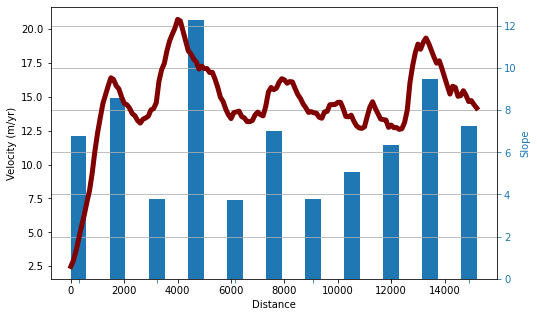

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('../analysis/csv/fil_points.csv')
# df['velocity'] = ((df['SAMPLE_1']**2) + (df['SAMPLE_2']**2))**0.5
df2 = pd.read_csv('../analysis/slopes.csv')

fig = plt.figure(figsize = (8, 5))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.bar(df2.index, df2['SAMPLE_1'], width = 0.4)
ax.grid(axis='y')
ax.yaxis.tick_right()
ax.axes.xaxis.set_ticklabels([])
ax.yaxis.set_label_position('right')
ax.set_xlabel("", color="C0")
ax.set_ylabel("Slope", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")


# ax2.plot(df['distance'], smooth(df['velocity'], 0.95), color ='maroon', linewidth=5.0)
ax2.plot(df['distance'], smooth(df['SAMPLE_1'], 0.95), color ='maroon', linewidth=5.0)
ax2.xaxis.set_label_position('bottom') 
ax2.yaxis.set_label_position('left')
ax2.set_xlabel('Distance') 
ax2.set_ylabel('Velocity (m/yr)')       
ax2.tick_params(axis='x')
ax2.tick_params(axis='y')
plt.title('')
plt.show()

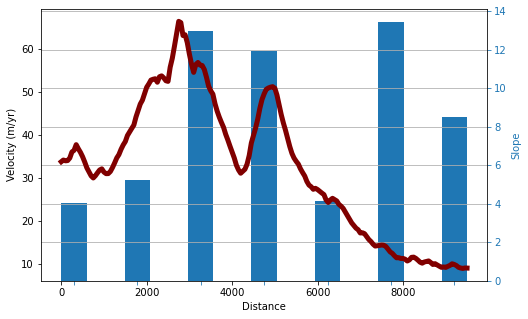

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../analysis/csv/fil_points_Al.csv')
# df['velocity'] = ((df['SAMPLE_1']**2) + (df['SAMPLE_2']**2))**0.5
df2 = pd.read_csv('../analysis/slopes_A.csv')

fig = plt.figure(figsize = (8, 5))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.bar(df2.index, df2['SAMPLE_1'], width = 0.4)
ax.grid(axis='y')
ax.yaxis.tick_right()
ax.axes.xaxis.set_ticklabels([])
ax.yaxis.set_label_position('right')
ax.set_xlabel("", color="C0")
ax.set_ylabel("Slope", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")


# ax2.plot(df['distance'], smooth(df['velocity'], 0.95), color ='maroon', linewidth=5.0)
# ax2.plot(df['distance'], smooth(df['velocity'], 0.95), color ='maroon', linewidth=5.0)
ax2.plot(df['distance'], smooth(df['SAMPLE_1'], 0.95), color ='maroon', linewidth=5.0)
ax2.xaxis.set_label_position('bottom') 
ax2.yaxis.set_label_position('left')
ax2.set_xlabel('Distance') 
ax2.set_ylabel('Velocity (m/yr)')       
ax2.tick_params(axis='x')
ax2.tick_params(axis='y')
plt.title('')
plt.show()

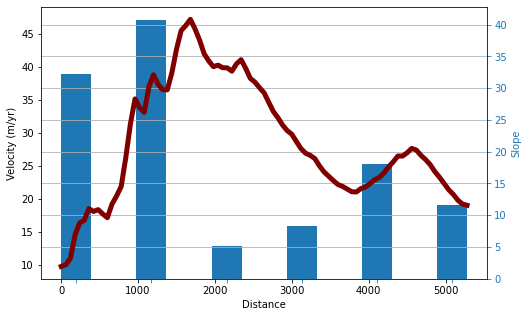

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../analysis/csv/fil_points_Bl.csv')
# df['velocity'] = ((df['SAMPLE_1']**2) + (df['SAMPLE_2']**2))**0.5
df2 = pd.read_csv('../analysis/slopes_B.csv')

fig = plt.figure(figsize = (8, 5))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.bar(df2.index, df2['SAMPLE_1'], width = 0.4)
ax.grid(axis='y')
ax.yaxis.tick_right()
ax.axes.xaxis.set_ticklabels([])
ax.yaxis.set_label_position('right')
ax.set_xlabel("", color="C0")
ax.set_ylabel("Slope", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")


# ax2.plot(df['distance'], smooth(df['velocity'], 0.95), color ='maroon', linewidth=5.0)
ax2.plot(df['distance'], smooth(df['SAMPLE_1'], 0.95), color ='maroon', linewidth=5.0)
ax2.xaxis.set_label_position('bottom') 
ax2.yaxis.set_label_position('left')
ax2.set_xlabel('Distance') 
ax2.set_ylabel('Velocity (m/yr)')       
ax2.tick_params(axis='x')
ax2.tick_params(axis='y')
plt.title('')
plt.show()

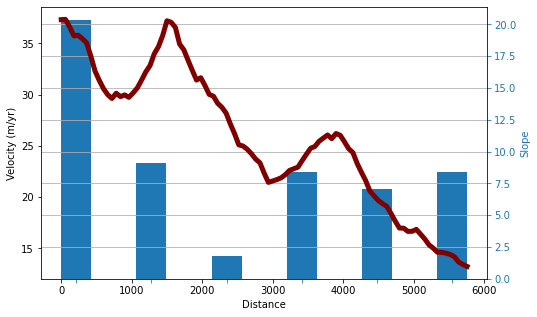

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../analysis/csv/fil_points_Cl.csv')
# df['velocity'] = ((df['SAMPLE_1']**2) + (df['SAMPLE_2']**2))**0.5
df2 = pd.read_csv('../analysis/slopes_C.csv')

fig = plt.figure(figsize = (8, 5))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.bar(df2.index, df2['SAMPLE_1'], width = 0.4)
ax.grid(axis='y')
ax.yaxis.tick_right()
ax.axes.xaxis.set_ticklabels([])
ax.yaxis.set_label_position('right')
ax.set_xlabel("", color="C0")
ax.set_ylabel("Slope", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")


# ax2.plot(df['distance'], smooth(df['velocity'], 0.95), color ='maroon', linewidth=5.0)
ax2.plot(df['distance'], smooth(df['SAMPLE_1'], 0.95), color ='maroon', linewidth=5.0)

ax2.xaxis.set_label_position('bottom') 
ax2.yaxis.set_label_position('left')
ax2.set_xlabel('Distance') 
ax2.set_ylabel('Velocity (m/yr)')       
ax2.tick_params(axis='x')
ax2.tick_params(axis='y')
plt.title('')
plt.show()

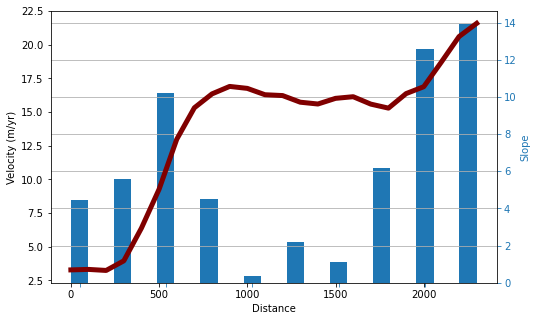

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../analysis/csv/fil_points_Dl.csv')
# df['velocity'] = ((df['SAMPLE_1']**2) + (df['SAMPLE_2']**2))**0.5
df2 = pd.read_csv('../analysis/slopes_D.csv')

fig = plt.figure(figsize = (8, 5))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.bar(df2.index, df2['SAMPLE_1'], width = 0.4)
ax.grid(axis='y')
ax.yaxis.tick_right()
ax.axes.xaxis.set_ticklabels([])
ax.yaxis.set_label_position('right')
ax.set_xlabel("", color="C0")
ax.set_ylabel("Slope", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")


# ax2.plot(df['distance'], smooth(df['velocity'], 0.95), color ='maroon', linewidth=5.0)
ax2.plot(df['distance'], smooth(df['SAMPLE_1'], 0.95), color ='maroon', linewidth=5.0)

ax2.xaxis.set_label_position('bottom') 
ax2.yaxis.set_label_position('left')
ax2.set_xlabel('Distance') 
ax2.set_ylabel('Velocity (m/yr)')       
ax2.tick_params(axis='x')
ax2.tick_params(axis='y')
plt.title('')
plt.show()

In [14]:
!ls ../analysis

center_line.cpg  center_line.shp  points.prj  values.dbf
center_line.dbf  center_line.shx  points.qmd  values.prj
center_line.prj  points.cpg	  points.shp  values.shp
center_line.qmd  points.dbf	  points.shx  values.shx


In [8]:
%cd /home/ayush12gupta/Desktop/ugp/offset_tracking

/home/ayush12gupta/Desktop/ugp/offset_tracking


In [7]:
ls

adv_G0028V02_P099.nc                  feb1test_G0028V02_P096.nc
apr/                                  feb1_test_G0028V02_P100.nc
apr1_G0028V02_P095.nc                 feb2_G0028V02_P097.nc
apr2_G0028V02_P092.nc                 feb3_G0028V02_P098.nc
apr3_G0028V02_P096.nc                 jan/
aug/                                  jan1_G0028V02_P098.nc
aug1_G0028V02_P098.nc                 jan2_G0028V02_P098.nc
aug2_G0028V02_P097.nc                 jan3_G0028V02_P098.nc
dec/                                  jun/
dec1_G0028V02_P099.nc                 jun1_G0028V02_P095.nc
dec2_G0028V02_P098.nc                 jun2_G0028V02_P095.nc
diag1/                                mar/
diag2/                                mar1_G0028V02_P099.nc
feb/                                  mar2_G0028V02_P095.nc
feb1_G0028V02_P096.nc                 mar3_G0028V02_P097.nc
feb1tes/                              may/
feb1test/                             may1_G0028V02_P095.nc
feb1test1/                            m

In [12]:
%cd /home/ayush12gupta/Desktop/ugp/offset_tracking
fl = os.listdir('./')
print(len(fl))
for file in fl:
    print(file)
    if '.nc' in file[:-4]:
        print(file)
        generateCrops(file)
# fl

/home/ayush12gupta/Desktop/ugp/offset_tracking
61
apr1_G0028V02_P095.nc
feb1test2_G0028V02_P100.nc
feb1tes
feb1test_G0028V02_P096.nc
feb1_test_G0028V02_P100.nc
oct2_G0028V02_P098.nc
jun2_G0028V02_P095.nc
may2_G0028V02_P092.nc
nov_prev
feb3_G0028V02_P098.nc
feb1test12825
dec
aug
diag1
plot.png
dec1_G0028V02_P099.nc
feb1test128256_G0028V02_P099.nc
sept1_G0028V02_P098.nc
oct1_G0028V02_P098.nc
jan1_G0028V02_P098.nc
aug1_G0028V02_P098.nc
feb1_G0028V02_P096.nc
aug2_G0028V02_P097.nc
jan2_G0028V02_P098.nc
adv_G0028V02_P099.nc
mar3_G0028V02_P097.nc
feb1test1
jun1_G0028V02_P095.nc
feb1test
may
feb2_G0028V02_P097.nc
feb1test3
apr2_G0028V02_P092.nc
plot.jpg
diag2
nov1_G0028V02_P100.nc
feb1test111_G0028V02_P096.nc
feb1test4_G0028V02_P099.nc
feb1test2
oct
apr3_G0028V02_P096.nc
may1_G0028V02_P095.nc
sept2_G0028V02_P097.nc
nov2_G0028V02_P097.nc
plot1.jpg
feb
feb1test6412
feb1test64128_G0028V02_P099.nc
mar
jan
sept
dec2_G0028V02_P098.nc
feb1test11
jan3_G0028V02_P098.nc
mar1_G0028V02_P099.nc
mar2_G0028V

In [39]:
out_meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -32767.0,
 'width': 2107,
 'height': 2575,
 'count': 4,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]'),
 'transform': Affine(27.724848095791327, 0.0, 706799.6419465062,
        0.0, -27.72484809579133, 3625453.917872462)}

In [37]:
# %cd feb1test11
fls = os.listdir('./')
out_img = 'out.tiff'
raster_filenm = 'feb1test111_V_full.tiff'
vfull = rasterio.open('feb1test111_V_full.tiff').read(1)
vbasin = rasterio.open('feb1test111_V_basin.tiff').read(1)
# stack = np.dstack((vfull, vbasin))
# read imagery file
with rasterio.open(raster_filenm) as src:
#     out_image, out_transform = mask(src, shapes, crop=True)
    out_meta = src.meta

# # Save clipped imagery
out_meta.update({"driver": "GTiff",
                 "count": 4})

with rasterio.open(out_img, 'w', **out_meta) as dest:
    for band_nr, src in enumerate(fls, start=1):
        with rasterio.open(src) as src1:
            dest.write_band(band_nr, src1.read(1))

# with rasterio.open(out_img, "w", **out_meta) as dest:
#     dest.write(stack, 4)

In [20]:
import numpy as np
va = np.array(file2read['va'])
va.flatten('F')
# va.shape

(9425080,)

In [18]:
ls /home/ayush12gupta/Desktop/ugp/analysis2/raster/comp/2016/

20160113_V_full.tiff  20160605_V_full.tiff  20161003_V_full.tiff
20160206_V_full.tiff  20160629_V_full.tiff  20161027_V_full.tiff
20160301_V_full.tiff  20160723_V_full.tiff  20161120_V_full.tiff
20160418_V_full.tiff  20160816_V_full.tiff  20161214_V_full.tiff
20160512_V_full.tiff  20160909_V_full.tiff


In [117]:
%cd /home/ayush12gupta/Desktop/ugp/offset_tracking
import netCDF4
# /home/ayush12gupta/Desktop/ugp/analysis2/raster/comp/2016/20160723_V_full.tiff

# file2read = netCDF4.Dataset('feb1test111_G0028V02_P096.nc','r')
deg2rad = np.pi/180
az_ang = 360 - 12.8160
incid_ang = 37.2114
vel = gdal.Open("/home/ayush12gupta/Desktop/ugp/analysis2/raster/comp/2016/20160723_V_full.tiff")
vx = vel.GetRasterBand(1).ReadAsArray().astype(float)
vy = vel.GetRasterBand(2).ReadAsArray().astype(float)
nodata = (vx==-32767)
va, vr = xy2rdr(vx, vy, nodata, az_ang, incid_ang)
shp = (va.shape)
va[nodata|np.isnan(vr)] = -32767  #np.nan
vr[nodata|np.isnan(vr)] = -32767  #np.nan
mask = (vr==-32767)
rsh_msk = mask.reshape(-1)
print(vr.min(), va.min())
P = [[1, 0], [0, 1]]
B = [[-np.cos(deg2rad*incid_ang), np.sin(deg2rad*incid_ang)*np.sin(deg2rad*az_ang - 1.5*np.pi), np.sin(deg2rad*incid_ang)*np.sin(deg2rad*az_ang - 1.5*np.pi)],
     [0, -np.cos(deg2rad*az_ang - 1.5*np.pi), np.sin(deg2rad*az_ang - 1.5*np.pi)]]
V = np.array([vr.reshape(-1), va.reshape(-1)])
X_bar = np.matmul(np.matmul(numpy.linalg.inv(np.matmul((np.transpose(B)@P),B)), (np.transpose(B)@P)), V).reshape(3, shp[0], shp[1])
X_bar[:,mask] = -32767

Resid = V - (B@(X_bar.reshape(3,-1)))
# *B*np.array([vr.flatten('F'), va.flatten('F')])
# ['img_pair_info']

/home/ayush12gupta/Desktop/ugp/offset_tracking
-32767.0 -32767.0


In [123]:
Resid[:,np.logical_not(rsh_msk)]

array([[-3.01810064, -3.13215088, -3.6902478 , ..., -5.91628729,
        -5.94691252, -5.70424065],
       [-3.80076368, -3.97017925, -4.27763379, ..., -7.9238924 ,
        -7.99098174, -7.65024242]])

In [115]:
# X_bar.reshape(3,-1)
# mask.reshape(-1)


array([ True,  True,  True, ...,  True,  True,  True])

In [101]:
output_path = 'Vxyz.tif'
ds = numpy_array_to_raster(output_path, X_bar.reshape(3, shp[0], shp[1]), projs, geo, nband=3)
ds.FlushCache()
ds = None 

2411 2007
(674777.4423958672, 27.724848095791327, 0.0, 3628864.074188244, 0.0, -27.72484809579133)
1
2
3


In [99]:
# np.matmul(numpy.linalg.inv(np.matmul(np.transpose(B),B)), np.transpose(B)).shape
# V[np.isnan(V)] = -32767
V.min()

-32767.0

In [49]:
tmp = np.zeros((3, vr.shape[0], vr.shape[1]))
for i in range(vr.shape[0]):
    for j in range(vr.shape[1]):
        if vr[i,j]!=0:
#             B = [[-np.cos(deg2rad*incid_ang), np.sin(deg2rad*incid_ang)*np.sin(deg2rad*az_ang - 1.5*np.pi), np.sin(deg2rad*incid_ang)*np.sin(deg2rad*az_ang - 1.5*np.pi)],
#      [0, -np.cos(deg2rad*az_ang - 1.5*np.pi), np.sin(deg2rad*az_ang - 1.5*np.pi)]]
            V = np.array([vr[i, j], va[i, j]])
            X_bar = np.matmul(np.matmul(numpy.linalg.inv(np.matmul(np.transpose(B),B)), np.transpose(B)), V)
            tmp[:,i,j] = X_bar

In [10]:
# X_bar.reshape(3, 2870, 3284).shape
X_bar[:, vr_nodt] = 0

In [50]:
tmp.shape

(3, 2870, 3284)

In [12]:
import netCDF4
#-----Params for velocity processing----------------
incidenceAngle = 37
# 41.8862
deg2rad = np.pi/180
sin_incid = np.sin(incidenceAngle*deg2rad)
cos_incid = np.cos(incidenceAngle*deg2rad)

#----------- Angle u-----------------------
demsp = gdal.Open('../dem_test.tif')
projs = demsp.GetProjection()
geo = demsp.GetGeoTransform()
nodata = demsp.GetRasterBand(1).GetNoDataValue()
angle_u = demsp.GetRasterBand(1).ReadAsArray()*deg2rad
angle_u_nodt = (angle_u==nodata)
demsp = None

#----------- Compute angle V------------------------
file2read = netCDF4.Dataset('jan_pair1_G0028V02_P098.nc','r')

vr = np.array(file2read['vr']).astype(float)
vr_nodt = (vr==-32767)
vr[vr_nodt] = 0  #np.nan
va = np.array(file2read['va']).astype(float)
va_nodt = (va==-32767)
va[va_nodt] = 0  #np.nan

nodata = (va!=0)
tmp = np.zeros_like(vr)
tmp[nodata] = (vr*sin_incid)[nodata]/va[nodata]
angle_v = np.arctan(tmp)

FileNotFoundError: [Errno 2] No such file or directory: b'jan_pair1_G0028V02_P098.nc'

In [9]:
# ds = gdal.Open('../slope_demroi.tif')

print(projs)
# demsp[demsp==-9999] = -32767
# # geo
# demsp.shape

PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]


(7871493,) -13077.228165238113 11634.656109911532 626.5653903468416


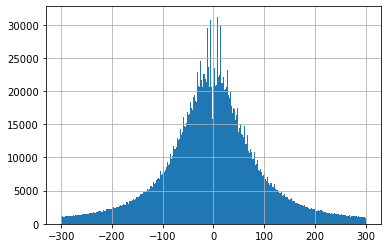

In [27]:
#--------------Flow velocity along the glacier plane--------------------
vf = vr*(((np.cos(angle_u)* np.sin(angle_v))*sin_incid) - (cos_incid*np.sin(angle_u))) + va*(np.cos(angle_u)*np.cos(angle_v))
vf[angle_u_nodt] = 0
vf[va_nodt] = -32767
vf[vr_nodt] = -32767

data = vf[vf!=-32767]
print(data.shape, data.min(), data.max(), data.std())

plt.hist(data, bins=1000, range=[-300,300])
plt.grid()

plt.show()

(7871493,) -9837.37950874012 9703.407370658677 258.9980166313128 84.07532886232343


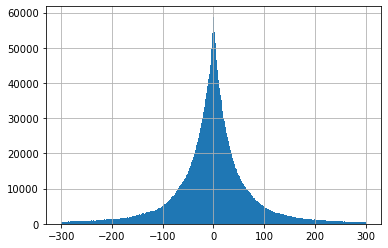

In [30]:
#------------Thickness change velocity------------------------
vn = vr*(((np.sin(angle_u)* np.sin(angle_v))*sin_incid) - (cos_incid*np.cos(angle_u))) + va*(np.sin(angle_u)*np.cos(angle_v))
vn[angle_u_nodt] = 0
vn[va_nodt] = -32767
vn[vr_nodt] = -32767

data = vn[vn!=-32767]
print(data.shape, data.min(), data.max(), data.std(), data[data>0].mean())

plt.hist(data, bins=1000, range=[-300,300])
plt.grid()

plt.show()

In [21]:
vf[vf>0].max()

11634.656109911532

In [22]:
vn[vn>0].max()

9703.407370658677

In [14]:
ls

ad/                                   feb2_G0028V02_P097.nc
adv_G0028V02_P099.nc                  feb3_G0028V02_P098.nc
apr/                                  jan/
apr1_G0028V02_P095.nc                 jan1_G0028V02_P098.nc
apr2_G0028V02_P092.nc                 jan2_G0028V02_P098.nc
apr3_G0028V02_P096.nc                 jan3_G0028V02_P098.nc
aug/                                  jul/
aug1_G0028V02_P098.nc                 jun/
aug1_G0028V02_P098.nc.aux.xml         jun1_G0028V02_P095.nc
aug2_G0028V02_P097.nc                 jun2_G0028V02_P095.nc
aug2_G0028V02_P097.nc.aux.xml         mar/
dec/                                  mar1_G0028V02_P099.nc
dec1_G0028V02_P099.nc                 mar2_G0028V02_P095.nc
dec2_G0028V02_P098.nc                 mar3_G0028V02_P097.nc
diag1/                                may/
diag2/                                may1_G0028V02_P095.nc
feb/                                  may1_G0028V02_P095.nc.aux.xml
feb1_G0028V02_P096.nc                 may2_G0028V02_P092.

In [52]:
from pyproj import Proj, transform
def transfPoint(x1, y1):
    outProj = Proj(init='epsg:32643')
    inProj = Proj(init='epsg:4326')
    x2,y2 = transform(inProj,outProj,x1,y1)
    return x2, y2
# print(transfPoint(674777.4423958672, 3549293.760153323))

In [62]:
def map_to_pixel(mx,my,gt):
    #Convert from map to pixel coordinates.
    #Only works for geotransforms with no rotation.
    px = int((mx - gt[0]) / gt[1]) #x pixel
    py = int((my - gt[3]) / gt[5]) #y pixel

    return px,py

def extent_to_offset(xmin,ymin,xmax,ymax,gt):
    pxmin,pymin = map_to_pixel(xmin,ymin,gt)
    pxmax,pymax = map_to_pixel(xmax,ymax,gt)
    print(pxmin, pymin, pxmax, pymax)
    return pxmin,pymin,pxmax-pxmin,pymax-pymin

In [63]:
# (np.array(val)*100)/365
ds = gdal.Open('Vf.tif')
projs = ds.GetProjection()
geo = ds.GetGeoTransform()
xoff, yoff, xsize, ysize = extent_to_offset(x1,y1,x2,y2,geo)
print(xoff, yoff, xsize, ysize)

1705 2056 1706 2056
1705 2056 1 0


In [83]:
import xarray as xr

# We define a location
lon1, lat1 = (77.3575, 32.2614)
lon2, lat2 = (77.3576, 32.2615)
# 32.2538N/77.3596E 32.2509N/77.3616E 5.30
x1, y1 = transfPoint(lon1, lat1)
x2, y2 = transfPoint(lon2, lat2)

print(x1, y1, x2, y2)

# In this example I am reading a file with (time, x, y) as dimensions
xarr = xr.open_rasterio('Vf.tif')

# Slice one of the bands
img = xarr[0, :, :]
# img
#Use the .sel() method to retrieve the value of the nearest cell close to your POI
val = img.sel(x=x2, y=y2, method="nearest")    
print("This is val: ", val)
val = img.sel(x=x1, y=y1, method="nearest")    
print("This is val: ", val)

722071.560912495 3571850.044141498 722080.7393134453 3571861.3399736956
This is val:  <xarray.DataArray ()>
array(-53.88326)
Coordinates:
    band     int64 1
    y        float64 3.572e+06
    x        float64 7.221e+05
Attributes:
    transform:      (27.724848095791327, 0.0, 674777.4423958672, 0.0, -27.724...
    crs:            +proj=utm +zone=43 +datum=WGS84 +units=m +no_defs=True
    res:            (27.724848095791327, 27.72484809579133)
    is_tiled:       0
    nodatavals:     (-32767.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
This is val:  <xarray.DataArray ()>
array(16.813273)
Coordinates:
    band     int64 1
    y        float64 3.572e+06
    x        float64 7.221e+05
Attributes:
    transform:      (27.724848095791327, 0.0, 674777.4423958672, 0.0, -27.724...
    crs:            +proj=utm +zone=43 +datum=WGS84 +units=m +no_defs=True
    res:            (27.724848095791327, 27.72484809579133)
    is_tiled:       0
    nodatavals:    

In [27]:
inv_geotransform = gdal.InvGeoTransform(geo)

bbox = [x1, y1, x2, y2]

_x0, _y0 = gdal.ApplyGeoTransform(inv_geotransform, bbox[0], bbox[1])
_x1, _y1 = gdal.ApplyGeoTransform(inv_geotransform, bbox[2], bbox[3])

print(_x0, _y0, _x1, _y1)

x0, y0 = min(_x0, _x1), min(_y0, _y1)
x1, y1 = max(_x0, _x1), max(_y0, _y1)

print(int(x0), int(y0), int(x1-x0), int(y1-y0))

-24335.820636980414 130888.51060100606 -24335.82063698038 130888.51060100603
-24335 130888 0 0


In [34]:
# (np.array(val)*100)/365
ds = gdal.Open('slope_dem.tif')
band = ds.GetRasterBand(1)
data = band.ReadAsArray()
data[va_nodt] = -32767

In [31]:
vf.shape

(2870, 3284)

In [12]:
# Combine
ds = gdal.Open('Vf.tif')
vf = ds.GetRasterBand(1).ReadAsArray()
ds = gdal.Open('Vn.tif')
vn = ds.GetRasterBand(1).ReadAsArray()
# v = np.sqrt(vn**2 + vf**2)
vf_u = vf[vf!=-32767]
vn_u = vn[vn!=-32767]

print(vf_u[vf_u<200].mean(), vn_u[vn_u<200].mean())
print(vf_u.std(), vn_u.std())

-60.65766403458969 -20.147036446516935
746.3834765581355 292.5115292117991


(7323933,) -10368.622611295426 11208.600150979737 292.5115292117991


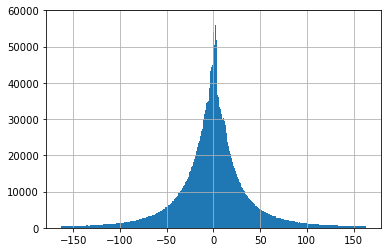

In [6]:
from shutil import copyfile, move # Utilities for copying and moving files
from osgeo import gdal, osr            # GDAL support for reading virtual files
import os                         # To create and remove directories
import matplotlib.pyplot as plt   # For plotting
import numpy as np                # Matrix calculations

data = vn_u
print(data.shape, data.min(), data.max(), data.std())

plt.hist(data, bins=1000, range=[-163,163])
plt.grid()

plt.show()

(7323933,) -12751.708394875124 13446.551143970775 746.3834765581355


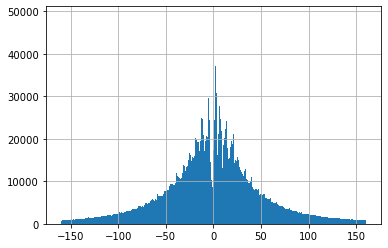

In [7]:
from shutil import copyfile, move # Utilities for copying and moving files
from osgeo import gdal, osr            # GDAL support for reading virtual files
import os                         # To create and remove directories
import matplotlib.pyplot as plt   # For plotting
import numpy as np                # Matrix calculations

data = vf_u
print(data.shape, data.min(), data.max(), data.std())

plt.hist(data, bins=1000, range=[-160,160])
plt.grid()

plt.show()

In [1]:
from osgeo import gdal, osr
import numpy as np

In [23]:
np.percentile(vf_u, 5)

-165.45005127142764

In [24]:
import fiona
import rasterio
from rasterio.mask import mask
from pyproj import Proj

In [14]:
with rasterio.open("Vff.tif") as src:
    out_image, out_transform = mask(src, shapes, invert=True)
    out_meta = src.meta